In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [4]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [5]:
# LOAD AND PREPARE MNIST DATA FOR UNSUPERVISED TRAINING

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")
#print(mat)

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data_mnist = M
print(f'Number of samples: {data_mnist.shape[0]}')
print(f'Number of features: {data_mnist.shape[1]}')

Loading MNIST...
Done loading MNIST
Number of samples: 60000
Number of features: 784


In [6]:
print(data_mnist.shape) # DEBUG line

(60000, 784)


In [7]:
# DEFINE BioClassifier AND BioLoss CLASSES TO PERFORM BIO-PLAUSIBLE LEARNING

# REFERENCED FROM https://github.com/gatapia/unsupervised_bio_classifier

class BioCell(nn.Module):
    def __init__(self, Wui, beta, out_features):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        # TODO: Does this need to be transposed here?
        # Answer: NO! Because we are using F.linear in the forward pass rather than multiplying directly ourselves.
        # F.linear does the transpose internally.
        self.Wui = Wui
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):
        Wui_vi = F.linear(vi, self.Wui, None)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca

    
class BioCell2(nn.Module):
    def __init__(self, Wui, beta=0.1, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):        
        # Different from BioCell where we do matmul here directly rather than using nn.Linear to accomplish the same.
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca


class BioCell3(nn.Module):
    def __init__(self, Wui, n=4.5, beta=.01, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.n = n
        self.beta = beta
        # Below can be renamed to self.supervised to be similar to previous cells
        self.Sau = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vᵢ):
        # vᵢ = vᵢ.view(-1, 28, 28).transpose(1, 2).contiguous().view(-1, 28*28) # change vᵢ to be HxW for testing
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using custom RELU as in the paper
        hu = F.relu(Wui_vi) ** self.n
        Sau_hu = self.Sau(hu)
        ca = torch.tanh(self.beta * Sau_hu)
        return ca

    
class BioLoss(nn.Module):
    def __init__(self, m=6):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

    
class BioClassifier(nn.Module):
    def __init__(self, bio):
        super().__init__()
        self.bio = bio

    def forward(self, vi):
        ca = self.bio(vi)
        return F.log_softmax(ca, dim=-1)



In [8]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

torch.Size([2000, 784])
tensor([[ 6.6274e-05,  5.6733e-06, -7.4061e-05,  ...,  5.4102e-05,
          7.7864e-05, -1.2874e-05],
        [-2.8026e-45, -2.8026e-45,  2.8026e-45,  ..., -2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [-2.8026e-45, -2.8026e-45, -2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        ...,
        [ 2.8026e-45,  2.8026e-45, -2.8026e-45,  ...,  2.8026e-45,
          2.8026e-45,  2.8026e-45],
        [-2.8026e-45, -2.8026e-45,  2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [ 4.2039e-45, -4.2039e-45,  4.2039e-45,  ..., -4.2039e-45,
         -4.2039e-45, -4.2039e-45]], device='cuda:0')


<IPython.core.display.Javascript object>


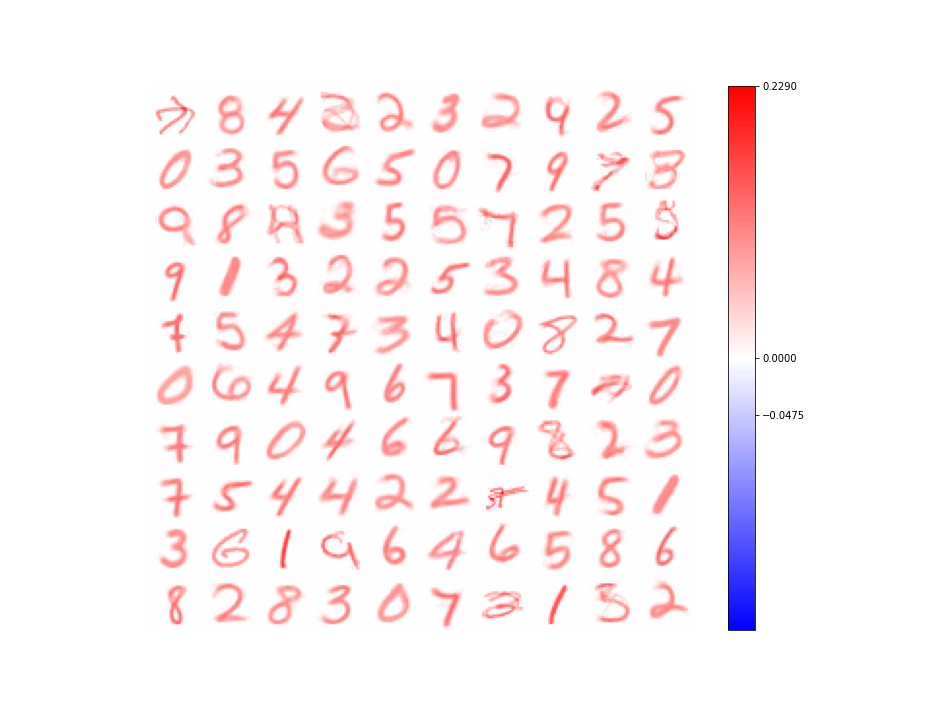

Fin


In [9]:
# TODO Read in the frozen weights_mnist from a file on disk

# LOAD weights_mnist from FILE
weights_mnist = torch.load('weights_mnist.pt')
print(weights_mnist.shape)
print(weights_mnist)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_mnist.cpu().numpy(), Kx, Ky)
print("Fin")

Completed downloading MNIST data.
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})
n_total_steps: 600
n_total_steps_sample: 1
batch_size: 100
i: 0, labels: tensor([4, 5, 4, 1, 4, 1, 0, 4, 1, 1, 0, 2, 1, 9, 9, 2, 4, 5, 1, 9, 0, 5, 2, 4,
        5, 9, 0, 2, 5, 3, 3, 4, 1, 4, 4, 5, 5, 5, 4, 4, 4, 4, 1, 1, 2, 4, 1, 1,
        4, 4, 0, 1, 2, 0, 3, 4, 3, 1, 3, 5, 5, 4, 3, 5, 0, 0, 3, 4, 1, 9, 4, 3,
        4, 1, 1, 1, 4, 1, 1, 1, 3, 2, 1, 3, 3, 3, 2, 2, 9, 0, 9, 4, 9, 9, 5, 2,
        1, 4, 1, 5])
0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine
images.shape: torch.Size([80, 1, 28, 28])
target.shape: torch.Size([80])


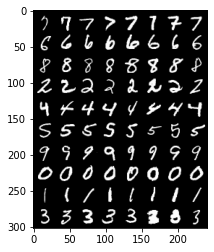

In [25]:
# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

from collections import Counter

#print(dict(Counter(train_dataset.targets)))
# labels in training set
train_classes = [label for _, label in train_dataset]
print(Counter(train_classes))

test_classes = [label for _, label in test_dataset]
print(Counter(test_classes))

#train_classes = [dataset.targets[i] for i in train_dataset.indices]
#print(Counter(train_classes))


# https://discuss.pytorch.org/t/train-on-a-fraction-of-the-data-set/16743/7
# https://discuss.pytorch.org/t/how-to-prevent-overfitting/1902/6
class_sample_count = [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
weights = 1 / torch.Tensor(class_sample_count)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
sample_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler = sampler)

n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

n_total_steps_sample = len(sample_train_loader)
print(f'n_total_steps_sample: {n_total_steps_sample}')

print(f'batch_size: {batch_size}')


for i, (images, labels) in enumerate(sample_train_loader):
    print(f'i: {i}, labels: {labels}')

for class_name in train_dataset.classes:
    print(class_name)

# https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/65198/4
# THIS LOOKS PROMISING

n_classes = 10
n_samples = 8

#mnist_train =  torchvision.datasets.MNIST(root="mnist/mnist_train", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]))

balanced_batch_sampler = BalancedBatchSampler(train_dataset, n_classes, n_samples)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=balanced_batch_sampler)
my_testiter = iter(dataloader)
images, target = my_testiter.next()

print(f'images.shape: {images.shape}')
print(f'target.shape: {target.shape}')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))


In [31]:
# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#from collections import Counter

# labels in training set
#train_classes = [label for _, label in train_dataset]
#print(Counter(train_classes))

#test_classes = [label for _, label in test_dataset]
#print(Counter(test_classes))


# https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/65198/4
# THIS LOOKS PROMISING

n_classes = 10
n_samples = 3000

#mnist_train =  torchvision.datasets.MNIST(root="mnist/mnist_train", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]))

balanced_batch_sampler = BalancedBatchSampler(train_dataset, n_classes, n_samples)

balanced_data_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=balanced_batch_sampler)
my_testiter = iter(balanced_data_loader)
images, target = my_testiter.next()

print(f'images.shape: {images.shape}')
print(f'target.shape: {target.shape}')

# Convert into numpy to get frequency count. Could not find how to do in PyTorch and got very, very annoyed.
unique_elements, counts_elements = np.unique(target.numpy(), return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

# This proves that the balanced_data_loader has 3000 of each class

Completed downloading MNIST data.
images.shape: torch.Size([30000, 1, 28, 28])
target.shape: torch.Size([30000])
Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9]
 [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]]


In [23]:
# SOURCED/REFERENCED FROM https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/65198/3

from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler


class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size (n_classes * n_samples)
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size